**In this notebook, I will be showing examples of how I modelled this data.**

In [20]:
import pandas as pd
import pickle
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import ElasticNetCV, RidgeCV, LinearRegression
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt

In [4]:
movie_features = pd.read_pickle('movies_newest_features.pkl')
movies_target = pd.read_pickle("movies_newest_target.pkl")

In [5]:
#Unknown (movie studio) only has one value so I'm dropping it
movie_features = movie_features.drop("Unknown", 1)

In [6]:
#splitting features and target into train and test sets
movies_train_features, movies_test_features, movies_train_target, movies_test_target = train_test_split(movie_features, movies_target, test_size=0.2)

In [7]:
#Taking the log of these three columns to help randomize and balance the residuals
movies_train_features = movies_train_features.reset_index(drop=True)

movies_train_features["Runtime"] = pd.DataFrame(np.log(movies_train_features["Runtime"]))
movies_train_features["Budget"] = pd.DataFrame(np.log(movies_train_features["Budget"]))
movies_train_features["week1gross"] = pd.DataFrame(np.log(movies_train_features["week1gross"]))
#movies_train_features = movies_train_features.drop(["Runtime", "Budget", "week1gross"], 1)

In [8]:
movies_test_features["Runtime"] = pd.DataFrame(np.log(movies_test_features["Runtime"]))
movies_test_features["Budget"] = pd.DataFrame(np.log(movies_test_features["Budget"]))
movies_test_features["week1gross"] = pd.DataFrame(np.log(movies_test_features["week1gross"]))



//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

In [9]:
#have to do log +1 on the target variables as there are negative values
#Also transforming these variables to make residuals more normally distributed
movies_train_target_log = np.log1p(movies_train_target)
movies_test_target_log = np.log1p(movies_test_target)

Now on to the machine learning!

In [16]:
elastic = ElasticNetCV(cv=5)

In [17]:
elastic.fit(movies_train_features , movies_train_target_log)
elastic.score(movies_train_features , movies_train_target_log)

0.30579870744862059

In [18]:
elastic.score(movies_test_features , movies_test_target_log)


0.31809441533996485

A bit weird the training r2 was worse than the test one...I definitely need more data.

In [22]:
Ridge = RidgeCV(cv=5)

In [23]:
Ridge.fit(movies_train_features, movies_train_target_log)
Ridge.score(movies_test_features , movies_test_target_log)


0.33328876383002703

Ridge performs slightly better than Elastic Net.

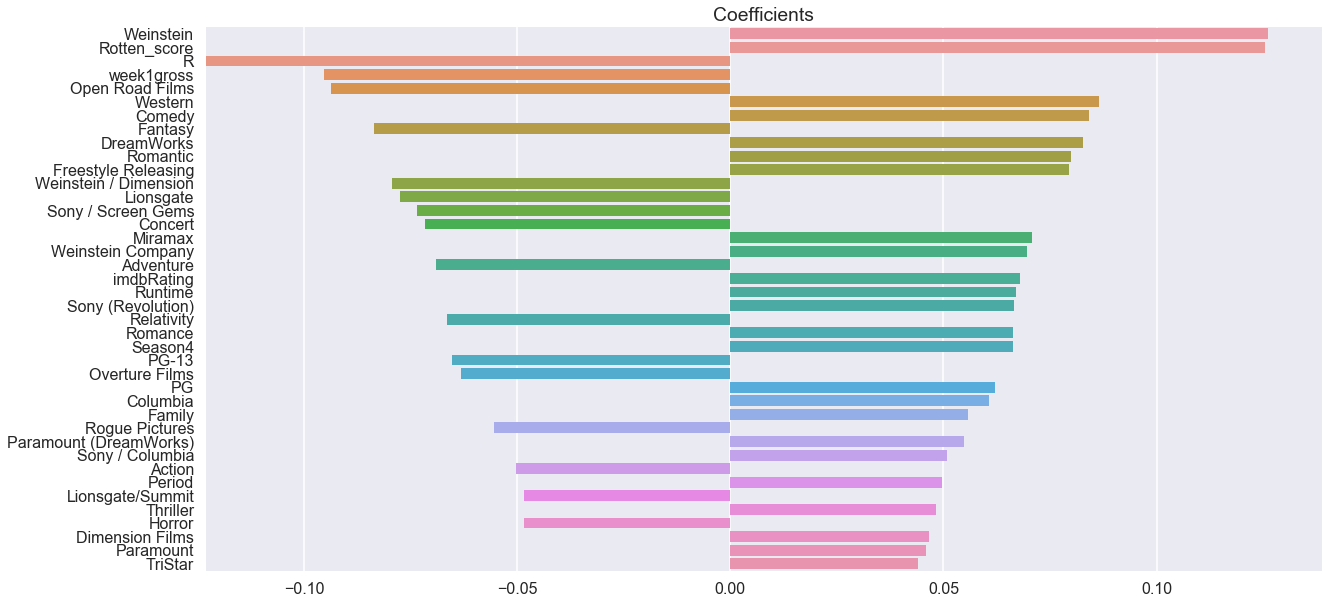

In [25]:
Coefs = sorted(zip(Ridge.coef_, movie_features.columns), reverse=True, key = lambda x: abs(x[0]))

Coefs1 = Coefs[0:40]
Coefs2= [x for x, y in Coefs1]
Coefs_name = [y for x, y in Coefs1]
Coefs_name[0] = "Weinstein"
plt.figure(figsize=(20,10))

#plt.barh(range(1,16), Coefs2)
#sns.plotting_context("notebook", font_scale=5.5)
ax = plt.axes()
#plt.yticks(range(1,26),Coefs_name , rotation="horizontal")
#ax.set_yticklabels(Coefs_name)
ax.set_title("Coefficients")
sns.set_context("poster", font_scale=1.0)
sns.barplot(y = Coefs_name, x=Coefs2, orient="h")
fig = ax.get_figure()
fig.savefig("Coefficients.png")

Weinstein is unsupringly a positive coefficient (positive meaning that they decrease box office gross loss) because they release many highly rated movies (like Django Unchained) around the holidays. Rotten Tomato score also makes sense as a positive coeffient. R makes sense as a negative one, as many R rated movies are probably seen for their grotesqueness, and are probably not that critically rated of movies (meaning a lot of people see them the first week and not many after because of bad ratings, etc.).

In [27]:
res = (pd.Series(Ridge.predict(movies_test_features)).reset_index()[0] -movies_test_target_log.reset_index()["grosschange"])

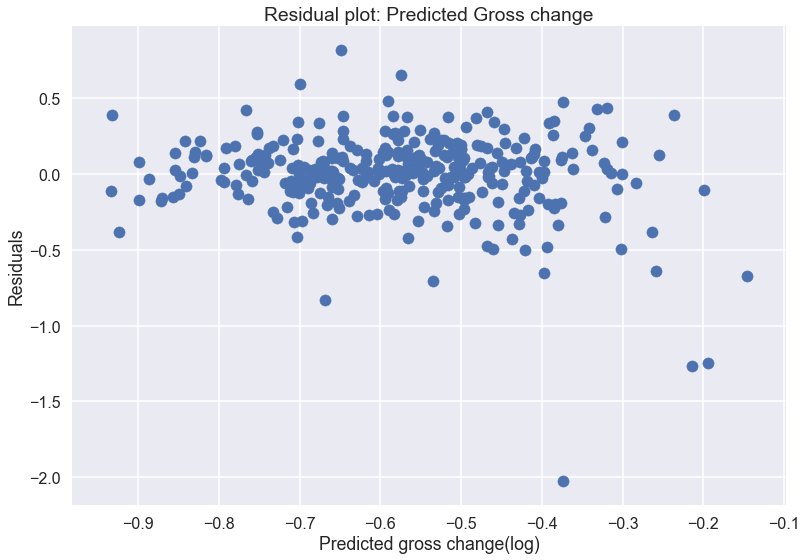

In [28]:
plt.scatter(pd.Series(Ridge.predict(movies_test_features)), res)
plt.title("Residual plot: Predicted Gross change")
plt.xlabel("Predicted gross change(log)")
plt.ylabel("Residuals")

The residuals look relatively good!

In [31]:
mean_squared_error(movies_test_target_log, Ridge.predict(movies_test_features))

0.06844647530624054

Based off my analyses in the other notebook, I believe there might be some non-linear interactions going on (like interactions between Genre, Holiday, and Metascore). So, I'm going to try Gradient Boosted trees.

In [32]:

param_grid = {'n_estimators':[100,200,300],
              'learning_rate':[0.001, 0.01, 0.1, 1.0],
              'max_depth': [1,3]}

gbt = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid)
gbt = gbt.fit(movies_train_features, movies_train_target_log)
r2_score(movies_test_target_log, gbt.predict(movies_test_features))

0.3098395502230642

GBT performs roughly as good as Elastic Net. Maybe the possible non-linearities don't make that much of a difference? I will need to explore this further.

In [119]:
gbt.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [34]:
mean_squared_error(movies_test_target_log, gbt.predict(movies_test_features))

0.070853838393924506